In [1]:
import pandas, warnings, datetime

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
urlfile = "/content/online_retail.csv"

origin = pandas.read_table(urlfile, parse_dates=["Date"], sep=",")

origin.iloc[:5, :5]

,Invoice,Stock,Description,Quantity,Date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00


In [3]:
origin.iloc[:5, 5:]

,Price,Customer,Country
0,6.95,13085.0,United Kingdom
1,6.75,13085.0,United Kingdom
2,6.75,13085.0,United Kingdom
3,2.10,13085.0,United Kingdom
4,1.25,13085.0,United Kingdom


In [4]:
origin.isnull().sum().sum()

0

In [5]:
right = origin["Date"].max()

right += datetime.timedelta(days=1)

right

Timestamp('2011-12-10 12:50:00')

In [6]:
origin = origin[(origin["Quantity"] > 0) & (origin["Price"] > 0)]

In [7]:
origin["Total"] = origin["Quantity"] * origin["Price"]

In [8]:
customer = origin.groupby("Customer").agg({
  "Date": lambda x: (right - x.max()).days,
  "Invoice": "nunique",
  "Total": "sum"
})

customer.columns = ["R", "F", "M"]

customer.iloc[:5]

,R,F,M
Customer,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [9]:
sample = origin[origin["Customer"] == 12347]

sample.sort_values("Date", ascending=False).iloc[:5, :5]

,Invoice,Stock,Description,Quantity,Date
802172,581180,23508,MINI PLAYING CARDS DOLLY GIRL,20,2011-12-07 15:52:00
802167,581180,23084,RABBIT NIGHT LIGHT,24,2011-12-07 15:52:00
802163,581180,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-07 15:52:00
802164,581180,21064,BOOM BOX SPEAKER BOYS,24,2011-12-07 15:52:00
802165,581180,84625A,PINK NEW BAROQUECANDLESTICK CANDLE,24,2011-12-07 15:52:00


In [10]:
sample["Invoice"].nunique()

8

In [11]:
sample["Invoice"].unique().tolist()[:5]

[529924, 537626, 542237, 549222, 556201]

In [12]:
sample["Invoice"].unique().tolist()[5:]

[562032, 573511, 581180]

In [13]:
sample["Total"].sum()

5633.320000000001

In [14]:
customer.mean().round(3).to_frame().rename(columns={0: "Mean"})

,Mean
R,201.332
F,6.289
M,3018.617


In [15]:
customer.std().round(3).to_frame().rename(columns={0: "Standar Deviation"})

,Standar Deviation
R,209.339
F,13.009
M,14737.731


In [16]:
customer.isnull().sum().sum()

0

In [17]:
import scipy.stats as stats

skewness = stats.skew(customer)

sampler = zip(["R", "F", "M"], skewness.round(3))

result = {i:j for i, j in sampler}

result

{'R': 0.887, 'F': 12.637, 'M': 25.308}

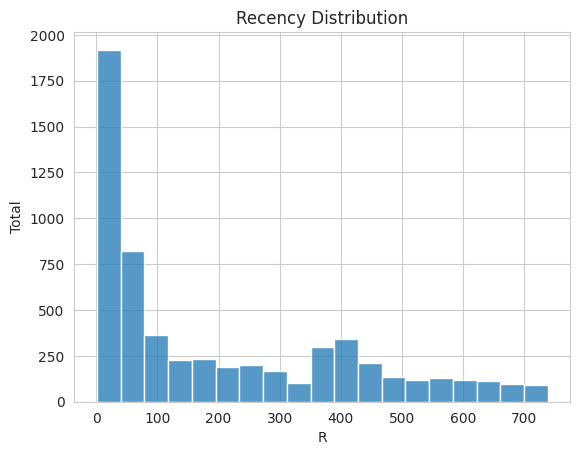

In [18]:
import seaborn as sns

sns.set_style("whitegrid")

plot = sns.histplot(customer["R"])

plot.set_ylabel("Total")

plot.set_title("Recency Distribution");

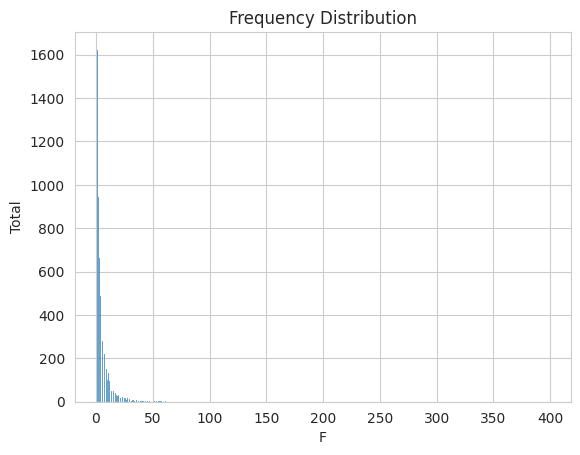

In [19]:
plot = sns.histplot(customer["F"])

plot.set_ylabel("Total")

plot.set_title("Frequency Distribution");

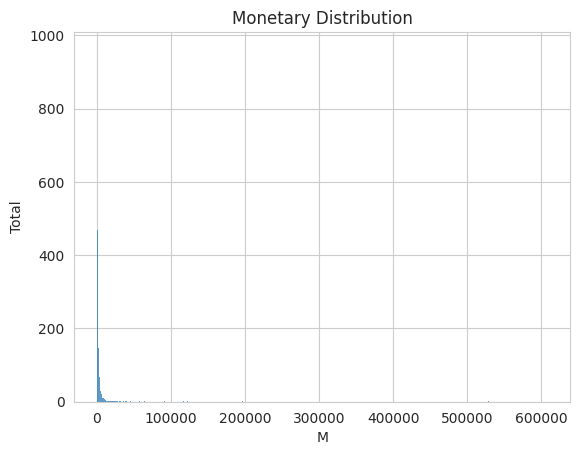

In [20]:
plot = sns.histplot(customer["M"])

plot.set_ylabel("Total")

plot.set_title("Monetary Distribution");

In [21]:
import numpy as np

custlog = customer.copy()

custlog["F"] = np.log(custlog["F"])

custlog["M"] = np.log(custlog["M"])

In [22]:
skewness = stats.skew(custlog)

sampler = zip(["R", "F", "M"], skewness.round(3))

result = {i:j for i, j in sampler}

result

{'R': 0.887, 'F': 0.612, 'M': 0.251}

In [23]:
custlog.iloc[:5]

,R,F,M
Customer,,,
12346.0,326,2.484907,11.258761
12347.0,2,2.079442,8.636454
12348.0,75,1.609438,7.610556
12349.0,19,1.386294,8.395859
12350.0,310,0.000000,5.812338


In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled = scaler.fit_transform(custlog)

scaled = pandas.DataFrame(scaled, columns=custlog.columns)

scaled.iloc[:5]

,R,F,M
0,0.440379,0.415088,0.831622
1,0.001355,0.347358,0.617337
2,0.100271,0.268847,0.533505
3,0.024390,0.231572,0.597677
4,0.418699,0.000000,0.386561


In [25]:
scaled.describe().round(3).loc[["min", "max", "mean", "std"]]

,R,F,M
min,0.000,0.000,0.000
max,1.000,1.000,1.000
mean,0.271,0.201,0.470
std,0.284,0.172,0.114


In [26]:
from sklearn.cluster import KMeans

inertia = []

for i in range(1, 11):
  # Define Cluster
  kmeans = KMeans(n_clusters=i)
  # Fit Scaled to Cluster
  kmeans.fit(scaled)
  # Find Inertia
  inertia.append(kmeans.inertia_)

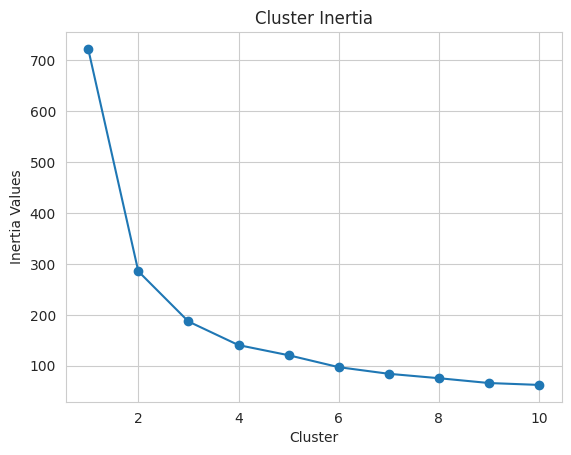

In [27]:
fig, ax = plt.subplots()

ax.plot([*range(1, 11)], inertia, marker="o")

ax.set_title("Cluster Inertia")

ax.set_xlabel("Cluster")

ax.set_ylabel("Inertia Values");